# ML in Cybersecurity: Project III

## Team
  * **Team name**:  *fill this in*
  * **Members**:  *fill this in. format: name1 (email1), name2 (email2), ...*
  * **Tutor**: *fill this in*


## Logistics
  * **Due date**: 12th December 2019, 13:59:59 
  * Email the completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws1920_stud) to discuss.
  
## Timeline
  * 28-Nov-2019: Project 3 hand-out
  * **12-Dec-2019** (13:59:59): Email completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland

  * 19-Dec-2019: Project 3 discussion and summary
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [25]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision

In [27]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [9]:
def identity_func(foo):
    return foo

#
#
# ------- Your Code -------
#
#

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Foolbox library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from project 1.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from project 1 here and train it until it achieves reasonable accuracy (>92%).

In [10]:
#
#
# ------- Your Code -------
#
#

# (1)load data 
# (2)define model
# (3)define loss, optimizer 
# (4)train
# (5)evaluate


print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_acc, test_acc))

NameError: name 'epoch' is not defined

In [11]:
batch_size_train = 64 
batch_size_test = 1000 
n_epochs = 12
learning_rate = 0.01
momentum = 0.5

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor()
                              ])), batch_size=batch_size_train, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                              ])), batch_size=batch_size_test, shuffle=True)



In [12]:
class Net(nn.Module):

    def __init__(self,kernels=5):
        super(Net, self).__init__()
        # 1 input image channel, 10 output channels, 5x5 square convolution
        # kernel 
        self.conv1 = nn.Conv2d(1, 10, kernel_size=kernels)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=kernels)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
def train(n_epochs):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))

            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
            torch.save(net.state_dict(), 'model_3.pth')
    train_losses.append(loss.item()) 

In [14]:
def test():
    net.eval()
    test_loss = 0 
    correct = 0 
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 
            100. * correct / len(test_loader.dataset)))

In [15]:
train_losses = []
train_counter = []
test_losses = []
train_accuracies = []
test_accuracies = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
net = Net()
optimizer = optim.SGD(net.parameters(), lr= learning_rate, momentum=momentum)

for epoch in range(1, n_epochs):
    train(epoch)
    test()

/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313071
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.273833
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.117910
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.467596
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.154780
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.100626
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.903262
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.760834
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.779079
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.684896


/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3343, Accuracy: 9082/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.529601
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.616678
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.538682
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.621214
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.453160
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.245588
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.401746
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.453412
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.395740
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.556283

Test set: Avg. loss: 0.1999, Accuracy: 9385/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.322680
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.756606
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.601465
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.389893
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.235579
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.438259
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.310439
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.534

### 1.1.2: Implementing an attack (15 Points)

We now want you to attack the model trained in the previous step. Please implement the FGSM attack mentioned in the lecture. 

In [46]:
#
#
# ------- Your Code -------
#
#
def FGSM(img, delt, gradient):
    grad_val = gradient.sign()
    purturbed_img = img + delt * grad_val
    return torch.clamp(purturbed_img,0,1)
    
    

In [69]:
def predict_purturbed_image(model, data_loader, deta, device):
    noisy_example_correct = []
    noise_example_wrong = []
    correct_example = 0
    
    for img, target in data_loader:
        img, target = img.to(device), target.to(device)
        img.requires_grad = True
        out = model(img)
        initial_prediction = out.max(1,keepdim=True)[1]
        if initial_prediction.item() != target.item():
            # Skip the iteration if the prediction is correct
            continue 
        
        loss = F.nll_loss(out, target)
        model.zero_grad()
        
        loss.backward()
        
        gradient_img = img.grad.data
        purturbed_img = FGSM(img, delta, gradient_img)
        out = model(purturbed_img)
        purturbed_out = out.max(1,keepdim=True)[1]
        if purturbed_out.item() == target.item():
            correct_example += 1
            if(len(noisy_example_correct)< 5):
                adv_example = purturbed_img.squeeze().detach().cpu().numpy()
                noisy_example_correct.append( (adv_example) )
        else :
            if len(noise_example_wrong) < 5 : 
                adv_example = purturbed_img.squeeze().detach().cpu().numpy()
                noisy_example_correct.append( (adv_example) )
        accuray = correct_example /float(len(data_loader)) 
        print('Accuracy : ', accuray, 'delta : ', delta )
        return accuray , noise_example_wrong, noisy_example_correct

In [70]:
model = Net()
model.load_state_dict(torch.load('model_3.pth'),strict=False)

<All keys matched successfully>

In [71]:
deltas = [0.01, 0.05, 0.15, 0.2, 0.25,0.3,0.35, 0.4,0.6]


accurcay = []
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/mnist/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor(),
                              ])), batch_size=1, shuffle=True)

for delta in deltas:
    accu, b, g =  predict_purturbed_image(model, test_loader, delta, device)
    accurcay.append(accu)
    
    
print (accurcay)

# choose best delta



Accuracy :  0.0001 delta :  0.01
Accuracy :  0.0001 delta :  0.05
Accuracy :  0.0001 delta :  0.15
Accuracy :  0.0001 delta :  0.2
Accuracy :  0.0 delta :  0.25
Accuracy :  0.0 delta :  0.3
Accuracy :  0.0 delta :  0.35
Accuracy :  0.0 delta :  0.4
Accuracy :  0.0 delta :  0.6
[0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0]


/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


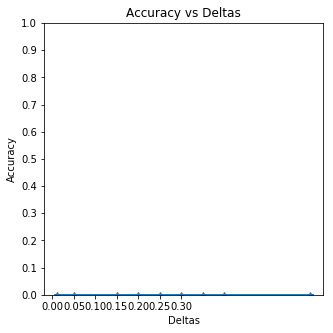

In [72]:
plt.figure(figsize=(5,5))
plt.plot(deltas, accurcay, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Deltas")
plt.xlabel("Deltas")
plt.ylabel("Accuracy")
plt.show()

### 1.1.3: adversarial sample set (5 Points)

Please additionally generate a dataset containing at least 1,000 adversarial examples using FGSM.

In [0]:
#
#
# ------- Your Code -------
#
#

### 1.1.3: Visualizing the results (5 Points)

Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

In [0]:
#
#
# ------- Your Code -------
#
#

### 1.2.1: Using libraries for attacks (10 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the Foolbox (https://github.com/bethgelab/foolbox) library. Please implement two other (recent, advanced) attacks of your choice using this library. 

In [0]:
#
#
# ------- Your Code -------
#
#

# (a) attack 1
# (b) attack 2

### 1.2.2: Visualizing the results (20 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (FGSM, 2 methods from Foolbox).


In [0]:
#
#
# ------- Your Code -------
#
#

# template code (Please feel free to change this)
# (each column corresponds to one attack method)
col_titles = ['Ori','FGSM','Method 1', 'Method 2'] 
nsamples = 10
nrows = nsamples
ncols = len(col_titles)

fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
[ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

for ax, col in zip(axes[0], col_titles): # set up the title for each column
    ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

for i in range(nsamples):
    axes[i,0].imshow(images_ori[i])
    axes[i,1].imshow(adv_FGSM[i])
    axes[i,2].imshow(adv_Method1[i])
    axes[i,3].imshow(adv_Method2[i])
                  

Which differences do you observe when comparing different attack methods? Why?   
Please write a brief summary of your findings.   
* Does the attack always succeed (the model make wrong prediction on the adversarial sample)?
* How different is the adversarial sample from the original image?
(L0,L2,Linf norm)  
* How about the computation cost of each attack method?
* Does the attack require white-box access to the model?
* .....

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM.   
Also, you are encouraged (optional) to defend against the two other attack methods, i.e. you are free to increase this special test set (for example by >30 examples (>10 from your FGSM attack, >10 from both the two other attacks of the library)).

In [0]:
#
#
# ------- Your Code -------
#
#
print('Accuracy on adversarial samples (FGSM) %.2f'%acc_FGSM)
print('Accuracy on adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend)

### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. 

* What did you try to make the classifier more robust against FGSM? 
* Why did it work? 
* Is the classifier now robust against FGSM?  
* ...

Feel free to state any interesting finding you encountered during this project.